#### ***Model build***

##### ***Aim:*** 
- To use the non-normalized rain data to infer seasonal patterns in the annual pollution level in the top 10 polluting rivers in South East Asia

##### ***Context:***
- **From the EDA**: There is clear evidence of seasonality in precipitation levels across South-East Asia and some evidence of correlation between yearly precipitation levels and annual pollution levels for each river

- Building on The Ocean Cleanup model which shows an annual pollution level for 1000 rivers

- Focusing on the top 10 polluting rivers in South East Asia

- Aiming to vizualise this on a map, with an interactive slider across each month

- In my simplified version, precipitation is used as a proxy for Mobilization (P(M)) from The Ocean Cleanup model
    - Mobilization is then related to plastic pollution




##### ***Packages:***

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import geopandas as gpd
import geodatasets
import contextily as cx
import matplotlib.pyplot as plt
from shapely.geometry import Point

#### ***Grabbing Dataframes:***

In [29]:
ts_df = pd.read_pickle(r'C:\\Users\\liamr\\OneDrive\\Documents\\Playground\\river_plastic_data\\data\\ts_df.pkl')
plastic_pollution = pd.read_pickle(r'C:\\Users\\liamr\\OneDrive\\Documents\\Playground\\river_plastic_data\\data\\SE_top_10_pts.pkl')
average_rain_and_pollution = pd.read_pickle(r'C:\\Users\\liamr\\OneDrive\\Documents\\Playground\\river_plastic_data\\data\\average_rain_and_pollution.pkl')

#### ***Model Version 1:***

##### ***Plan:***

- Create a **weighted distribution** of the annual plastic pollution, by river
- - Weighted acoording to precipitation variation across the months at each location


##### ***Inputs:***

- Annual plastic pollution
- Monthly precipitation values (averaged across years 2000-2019)
- Annual Precipitation 


##### ***Weighted Distibution Model:***

##### *Monthly Pollution = Annual Pollution x Weight*
- Where Weight = Monthly Distribution/Total Annual Precipitation




In [3]:
ts_df

,river_ID,country,lon,lat,year,month,avg_precipitation
0,1,Malaysia,101.38875,3.00292,1960,1,263.625
1,2,Vietnam,106.74708,10.49875,1960,1,4.725
2,3,Thailand,100.55795,13.61573,1960,1,4.750
3,4,Myanmar,96.19083,16.77458,1960,1,7.125
4,5,Malaysia,110.39875,1.55542,1960,1,717.250
...,...,...,...,...,...,...,...
7195,6,Malaysia,101.41125,2.80458,2019,12,30.000
7196,7,Myanmar,96.10625,16.84125,2019,12,32.000
7197,8,Malaysia,102.24458,6.18208,2019,12,29.500
7198,9,Malaysia,103.34292,3.80625,2019,12,30.000


In [4]:
plastic_pollution

,pollution_volume,geometry,lat,lon,rank,country
1,12816.00,POINT (101.38875 3.00292),3.00292,101.38875,1,Malaysia
2,4127.44,POINT (106.74708 10.49875),10.49875,106.74708,2,Vietnam
3,4027.33,POINT (100.55795 13.61573),13.61573,100.55795,3,Thailand
4,3615.39,POINT (96.19083 16.77458),16.77458,96.19083,4,Myanmar
5,3274.70,POINT (110.39875 1.55542),1.55542,110.39875,5,Malaysia
6,2829.21,POINT (101.41125 2.80458),2.80458,101.41125,6,Malaysia
7,2488.62,POINT (96.10625 16.84125),16.84125,96.10625,7,Myanmar
8,2466.92,POINT (102.24458 6.18208),6.18208,102.24458,8,Malaysia
9,2186.88,POINT (103.34292 3.80625),3.80625,103.34292,9,Malaysia
10,2143.48,POINT (103.7975 1.49625),1.49625,103.79750,10,Malaysia


In [5]:
average_rain_and_pollution

,river_ID,avg_precip_river,pollution_volume,geometry,lat,lon,rank,country
0,1,31.795834,12816.00,POINT (101.38875 3.00292),3.00292,101.38875,1,Malaysia
1,2,31.095835,4127.44,POINT (106.74708 10.49875),10.49875,106.74708,2,Vietnam
2,3,32.706245,4027.33,POINT (100.55795 13.61573),13.61573,100.55795,3,Thailand
3,4,32.603127,3615.39,POINT (96.19083 16.77458),16.77458,96.19083,4,Myanmar
4,5,31.692709,3274.70,POINT (110.39875 1.55542),1.55542,110.39875,5,Malaysia
5,6,31.141668,2829.21,POINT (101.41125 2.80458),2.80458,101.41125,6,Malaysia
6,7,32.728127,2488.62,POINT (96.10625 16.84125),16.84125,96.10625,7,Myanmar
7,8,31.064587,2466.92,POINT (102.24458 6.18208),6.18208,102.24458,8,Malaysia
8,9,31.174999,2186.88,POINT (103.34292 3.80625),3.80625,103.34292,9,Malaysia
9,10,30.648960,2143.48,POINT (103.7975 1.49625),1.49625,103.79750,10,Malaysia


In [6]:
# for river in rivers:

# group the ts_df by river and month, and calculate the average monthly precipitation for each river
monthly_precipitation = ts_df.groupby(['river_ID', 'month']).agg(avg_monthly_rain=('avg_precipitation','mean')).reset_index()

# sum the avg_pollution across months for each river, naming the new column avg_yearly_pollution
yearly_precipitation = monthly_precipitation.groupby(['river_ID']).agg(avg_yearly_rain=('avg_monthly_rain','sum')).reset_index()

# calculating the weights
weights = pd.merge(monthly_precipitation, yearly_precipitation, how='left', on='river_ID')
weights['weight'] = weights['avg_monthly_rain'] / weights['avg_yearly_rain']
countries = average_rain_and_pollution[['river_ID', 'country','lon','lat']]
weights = pd.merge(weights, countries, how='left', on='river_ID')

In [7]:
weights

,river_ID,month,avg_monthly_rain,avg_yearly_rain,weight,country,lon,lat
0,1,1,57.581249,704.434143,0.081741,Malaysia,101.38875,3.00292
1,1,2,47.967915,704.434143,0.068094,Malaysia,101.38875,3.00292
2,1,3,61.775414,704.434143,0.087695,Malaysia,101.38875,3.00292
3,1,4,64.261253,704.434143,0.091224,Malaysia,101.38875,3.00292
4,1,5,54.627918,704.434143,0.077549,Malaysia,101.38875,3.00292
...,...,...,...,...,...,...,...,...
115,10,8,45.442501,704.796265,0.064476,Malaysia,103.79750,1.49625
116,10,9,47.408749,704.796265,0.067266,Malaysia,103.79750,1.49625
117,10,10,55.966251,704.796265,0.079408,Malaysia,103.79750,1.49625
118,10,11,67.606247,704.796265,0.095923,Malaysia,103.79750,1.49625


In [8]:
fig = px.bar(weights, x='month', y='weight', color='river_ID', title='Weights for each river')
fig.show()


In [9]:
# visualising the monthly rainfall for each river and showing 10 plots in a grid of 2x5 that show x=month, y=weight
river_1 = weights[weights['river_ID'] == 1]
river_name1 = river_1['country'][river_1['month'] == 1].iloc[0]
fig1 = px.bar(river_1, x='month', y='weight', title='Weights for River 1')

river_2 = weights[weights['river_ID'] == 2]
river_name2 = river_2['country'][river_2['month'] == 1].iloc[0]
fig2 = px.bar(river_2, x='month', y='weight', title='Weights for River 2')

river_3 = weights[weights['river_ID'] == 3]
river_name3 = river_3['country'][river_3['month'] == 1].iloc[0]
fig3 = px.bar(river_3, x='month', y='weight', title='Weights for River 3')

river_4 = weights[weights['river_ID'] == 4]
river_name4 = river_4['country'][river_4['month'] == 1].iloc[0]
fig4 = px.bar(river_4, x='month', y='weight', title='Weights for River 4')

river_5 = weights[weights['river_ID'] == 5]
river_name5 = river_5['country'][river_5['month'] == 1].iloc[0]
fig5 = px.bar(river_5, x='month', y='weight', title='Weights for River 5')

river_6 = weights[weights['river_ID'] == 6]
river_name6 = river_6['country'][river_6['month'] == 1].iloc[0]
fig6 = px.bar(river_6, x='month', y='weight', title='Weights for River 6')

river_7 = weights[weights['river_ID'] == 7]
river_name7 = river_7['country'][river_7['month'] == 1].iloc[0]
fig7 = px.bar(river_7, x='month', y='weight', title='Weights for River 7')

river_8 = weights[weights['river_ID'] == 8]
river_name8 = river_8['country'][river_8['month'] == 1].iloc[0]
fig8 = px.bar(river_8, x='month', y='weight', title='Weights for River 8')

river_9 = weights[weights['river_ID'] == 9]
river_name9 = river_9['country'][river_9['month'] == 1].iloc[0]
fig9 = px.bar(river_9, x='month', y='weight', title='Weights for River 9')

river_10 = weights[weights['river_ID'] == 10]
river_name10 = river_10['country'][river_10['month'] == 1].iloc[0]
fig10 = px.bar(river_10, x='month', y='weight', title='Weights for River 10')

# titles = (f'{river_name1}', f'{river_name2}', f'{river_name3}', f'{river_name4}', f'{river_name5}', f'{river_name6}', f'{river_name7}', f'{river_name8}', f'{river_name9}', f'{river_name10}')

# assign the titles to equal to the river_name variable of each river
titles = [f'River 1: {river_name1}', f'River 2: {river_name2}', f'River 3: {river_name3}', f'River 4: {river_name4}', 
f'River 5: {river_name5}', f'River 6: {river_name6}', f'River 7: {river_name7}', f'River 8: {river_name8}', f'River 9: {river_name9}', f'River 10: {river_name10}']
# titles = f'River 1: {river_name1}', f'River 2: {river_name2}', f'River 3: {river_name3}', f'River 4: {river_name4}', 
# f'River 5: {river_name5}', f'River 6: {river_name6}', f'River 7: {river_name7}', f'River 8: {river_name8}', f'River 9: {river_name9}', f'River 10: {river_name10}'

# make subplots
fig = make_subplots(rows=2, cols=5, subplot_titles=titles)
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)
fig.add_trace(fig3.data[0], row=1, col=3)
fig.add_trace(fig3.data[0], row=1, col=4)
fig.add_trace(fig3.data[0], row=1, col=5)
fig.add_trace(fig3.data[0], row=2, col=1)
fig.add_trace(fig3.data[0], row=2, col=2)
fig.add_trace(fig3.data[0], row=2, col=3)
fig.add_trace(fig3.data[0], row=2, col=4)
fig.add_trace(fig3.data[0], row=2, col=5)

# add title to the figure
fig.update_layout(title_text="River Weights", title_x=0.5)
fig.show()


##### ***Weighted Distibution of Annual Pollution:***

In [10]:
pollution_volume = average_rain_and_pollution[['river_ID', 'pollution_volume']]

In [11]:
pollution_volume = average_rain_and_pollution[['river_ID', 'pollution_volume']]

monthly_pollution_df = pd.merge(weights, pollution_volume, how='left', on='river_ID')

In [12]:
# for each river, create a new column that is monthly_pollution. This is equal to annual pollution x weight for each river and each month
monthly_pollution_df['monthly_pollution'] = monthly_pollution_df['pollution_volume'] * monthly_pollution_df['weight']
monthly_pollution_df

,river_ID,month,avg_monthly_rain,avg_yearly_rain,weight,country,lon,lat,pollution_volume,monthly_pollution
0,1,1,57.581249,704.434143,0.081741,Malaysia,101.38875,3.00292,12816.00,1047.594441
1,1,2,47.967915,704.434143,0.068094,Malaysia,101.38875,3.00292,12816.00,872.695953
2,1,3,61.775414,704.434143,0.087695,Malaysia,101.38875,3.00292,12816.00,1123.900203
3,1,4,64.261253,704.434143,0.091224,Malaysia,101.38875,3.00292,12816.00,1169.125923
4,1,5,54.627918,704.434143,0.077549,Malaysia,101.38875,3.00292,12816.00,993.863535
...,...,...,...,...,...,...,...,...,...,...
115,10,8,45.442501,704.796265,0.064476,Malaysia,103.79750,1.49625,2143.48,138.203188
116,10,9,47.408749,704.796265,0.067266,Malaysia,103.79750,1.49625,2143.48,144.183091
117,10,10,55.966251,704.796265,0.079408,Malaysia,103.79750,1.49625,2143.48,170.208816
118,10,11,67.606247,704.796265,0.095923,Malaysia,103.79750,1.49625,2143.48,205.609254


In [13]:
river1 = monthly_pollution_df[monthly_pollution_df['river_ID'] == 1]
river_country1 = monthly_pollution_df['country'][monthly_pollution_df['month'] == 1].iloc[0]
fig_pollution_1 = px.bar(river1, x='month', y='monthly_pollution', title='Monthly Pollution for River 1')

river2 = monthly_pollution_df[monthly_pollution_df['river_ID'] == 2]
river_country2 = river_2['country'][river_2['month'] == 1].iloc[0]
fig_pollution_2 = px.bar(river2, x='month', y='monthly_pollution', title='Monthly Pollution for River 2')

river3 = monthly_pollution_df[monthly_pollution_df['river_ID'] == 3]
river_country3 = river_3['country'][river_3['month'] == 1].iloc[0]
fig_pollution_3 = px.bar(river3, x='month', y='monthly_pollution', title='Monthly Pollution for River 3')

river4 = monthly_pollution_df[monthly_pollution_df['river_ID'] == 4]
river_country4 = river_4['country'][river_4['month'] == 1].iloc[0]
fig_pollution_4 = px.bar(river4, x='month', y='monthly_pollution', title='Monthly Pollution for River 4')

river5 = monthly_pollution_df[monthly_pollution_df['river_ID'] == 5]
river_country5 = river_5['country'][river_5['month'] == 1].iloc[0]
fig_pollution_5 = px.bar(river5, x='month', y='monthly_pollution', title='Monthly Pollution for River 5')

river6 = monthly_pollution_df[monthly_pollution_df['river_ID'] == 6]
river_country6 = river_6['country'][river_6['month'] == 1].iloc[0]
fig_pollution_6 = px.bar(river6, x='month', y='monthly_pollution', title='Monthly Pollution for River 6')

river7 = monthly_pollution_df[monthly_pollution_df['river_ID'] == 7]
river_country7 = river_7['country'][river_7['month'] == 1].iloc[0]
fig_pollution_7 = px.bar(river7, x='month', y='monthly_pollution', title='Monthly Pollution for River 7')

river8 = monthly_pollution_df[monthly_pollution_df['river_ID'] == 8]
river_country8 = river_8['country'][river_8['month'] == 1].iloc[0]
fig_pollution_8 = px.bar(river8, x='month', y='monthly_pollution', title='Monthly Pollution for River 8')

river9 = monthly_pollution_df[monthly_pollution_df['river_ID'] == 9]
river_country9 = river_9['country'][river_9['month'] == 1].iloc[0]
fig_pollution_9 = px.bar(river9, x='month', y='monthly_pollution', title='Monthly Pollution for River 9')

river10 = monthly_pollution_df[monthly_pollution_df['river_ID'] == 10]
river_country10 = river_10['country'][river_10['month'] == 1].iloc[0]
fig_pollution_10 = px.bar(river10, x='month', y='monthly_pollution', title='Monthly Pollution for River 10')

# titles = (f'{river_name1}', f'{river_name2}', f'{river_name3}', f'{river_name4}', f'{river_name5}', f'{river_name6}', f'{river_name7}', f'{river_name8}', f'{river_name9}', f'{river_name10}')

# assign the titles to equal to the river_name variable of each river
titles = [f'River 1: {river_country1}', f'River 2: {river_country2}', f'River 3: {river_country3}', f'River 4: {river_country4}', 
f'River 5: {river_country5}', f'River 6: {river_country6}', f'River 7: {river_country7}', f'River 8: {river_country8}', f'River 9: {river_country9}', f'River 10: {river_country10}']
# titles = f'River 1: {river_name1}', f'River 2: {river_name2}', f'River 3: {river_name3}', f'River 4: {river_name4}', 
# f'River 5: {river_name5}', f'River 6: {river_name6}', f'River 7: {river_name7}', f'River 8: {river_name8}', f'River 9: {river_name9}', f'River 10: {river_name10}'

# make subplots
fig_pollution = make_subplots(rows=2, cols=5, subplot_titles=titles)
fig_pollution.add_trace(fig_pollution_1.data[0], row=1, col=1)
fig_pollution.add_trace(fig_pollution_2.data[0], row=1, col=2)
fig_pollution.add_trace(fig_pollution_3.data[0], row=1, col=3)
fig_pollution.add_trace(fig_pollution_4.data[0], row=1, col=4)
fig_pollution.add_trace(fig_pollution_5.data[0], row=1, col=5)
fig_pollution.add_trace(fig_pollution_6.data[0], row=2, col=1)
fig_pollution.add_trace(fig_pollution_7.data[0], row=2, col=2)
fig_pollution.add_trace(fig_pollution_8.data[0], row=2, col=3)
fig_pollution.add_trace(fig_pollution_9.data[0], row=2, col=4)
fig_pollution.add_trace(fig_pollution_10.data[0], row=2, col=5)

# add title to the figure
fig_pollution.update_layout(title_text="River Pollution by Month", title_x=0.5)

# fig_pollution.subplots_adjust(wspace=0.3, hspace=0.5)  # Increase spacing

# update the colors to red
fig_pollution.update_traces(marker_color='red')
fig_pollution.show()


##### ***Vizualising***
- Spatially vizualizing the weighted distribution of plastic pollution

##### First using geopandas:

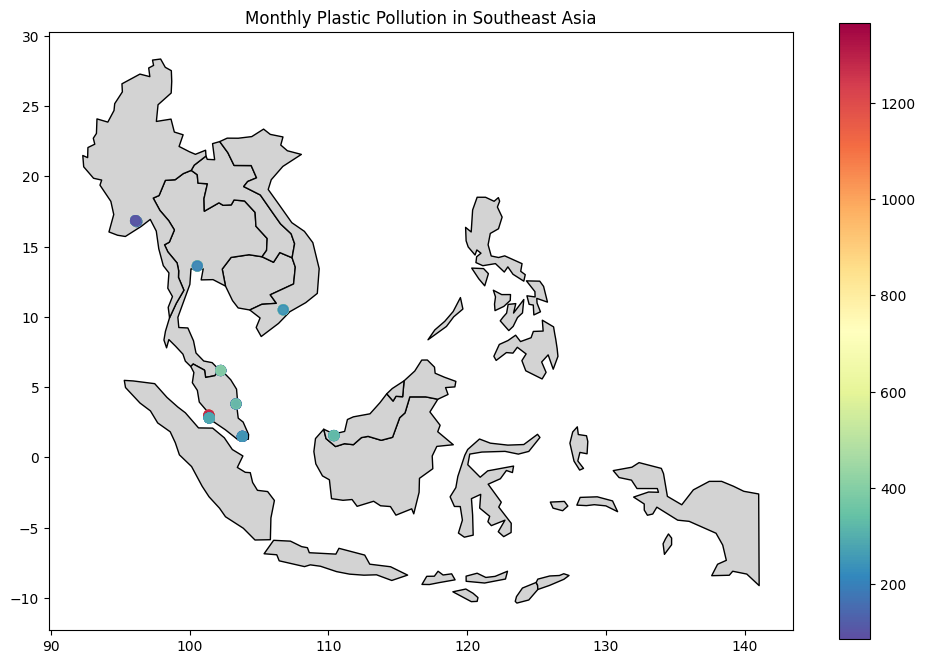

In [15]:
# Combining lon and lat to get single coordinates for each river
monthly_pollution_df['coordinates'] = [Point(xy) for xy in zip(monthly_pollution_df['lon'], monthly_pollution_df['lat'])]

# Load the world shapefile
world = gpd.read_file("C:\\Users\\liamr\\OneDrive\\Documents\\Playground\\river_plastic\\data\\ne_110m_admin_0_countries.shp")

# Create GeoDataFrame for rivers
rivers = gpd.GeoDataFrame(
    monthly_pollution_df,
    geometry=monthly_pollution_df['coordinates']
)

# Ensure CRS is consistent
rivers = rivers.set_crs(world.crs, allow_override=True)

# List of Southeast Asian countries
southeast_asia_countries = [
    "Brunei", "Cambodia", "East Timor", "Indonesia", "Laos",
    "Malaysia", "Myanmar", "Philippines", "Singapore", "Thailand", "Vietnam"
]

# Filter the world GeoDataFrame for Southeast Asia
southeast_asia = world[world['ADMIN'].isin(southeast_asia_countries)]

# Plot map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
southeast_asia.plot(ax=ax, color='lightgrey', edgecolor='black')  # Plot countries
# rivers.plot(ax=ax, column='monthly_pollution', cmap='Spectral', legend=True)
rivers.plot(
    ax=ax,
    column='monthly_pollution',
    cmap='Spectral_r',
    legend=True,
    markersize=50,  # Reduce marker size
    alpha=0.7       # Add transparency
)  # Plot rivers

plt.title("Monthly Plastic Pollution in Southeast Asia")
plt.show()

#### Using Plotly to map the change in plastic pollution each month:

In [16]:
# Merge the rank column from average_rain_and_pollution into monthly_pollution_df
monthly_pollution_df = pd.merge(monthly_pollution_df, average_rain_and_pollution[['river_ID', 'rank']], how='left', on='river_ID')
monthly_pollution_df

,river_ID,month,avg_monthly_rain,avg_yearly_rain,weight,country,lon,lat,pollution_volume,monthly_pollution,coordinates,rank
0,1,1,57.581249,704.434143,0.081741,Malaysia,101.38875,3.00292,12816.00,1047.594441,POINT (101.38875 3.00292),1
1,1,2,47.967915,704.434143,0.068094,Malaysia,101.38875,3.00292,12816.00,872.695953,POINT (101.38875 3.00292),1
2,1,3,61.775414,704.434143,0.087695,Malaysia,101.38875,3.00292,12816.00,1123.900203,POINT (101.38875 3.00292),1
3,1,4,64.261253,704.434143,0.091224,Malaysia,101.38875,3.00292,12816.00,1169.125923,POINT (101.38875 3.00292),1
4,1,5,54.627918,704.434143,0.077549,Malaysia,101.38875,3.00292,12816.00,993.863535,POINT (101.38875 3.00292),1
...,...,...,...,...,...,...,...,...,...,...,...,...
115,10,8,45.442501,704.796265,0.064476,Malaysia,103.79750,1.49625,2143.48,138.203188,POINT (103.7975 1.49625),10
116,10,9,47.408749,704.796265,0.067266,Malaysia,103.79750,1.49625,2143.48,144.183091,POINT (103.7975 1.49625),10
117,10,10,55.966251,704.796265,0.079408,Malaysia,103.79750,1.49625,2143.48,170.208816,POINT (103.7975 1.49625),10
118,10,11,67.606247,704.796265,0.095923,Malaysia,103.79750,1.49625,2143.48,205.609254,POINT (103.7975 1.49625),10


##### starting with plot for month of January

In [17]:
import plotly.graph_objects as go

months = sorted(monthly_pollution_df['month'].unique())
fig = go.Figure()

# Create traces (one for each month)
for i, month in enumerate(months):
    geo_df = monthly_pollution_df[monthly_pollution_df['month'] == month]
    
    fig.add_trace(go.Scattergeo(
        lat=geo_df['lat'],
        lon=geo_df['lon'],
        text=geo_df['river_ID'],
        mode='markers',
        marker=dict(
            size=12,
            color=geo_df['monthly_pollution'],
            colorscale='Viridis',
            colorbar_title='Pollution',
            cmin=monthly_pollution_df['monthly_pollution'].min(),
            cmax=monthly_pollution_df['monthly_pollution'].max(),
        ),
        name=f'Month {month}',
        visible=(i == 0)
    ))

# Add slider steps
steps = []
for i, month in enumerate(months):
    step = dict(
        method='update',
        args=[{'visible': [j == i for j in range(len(months))]},
              {'title': f'Monthly Pollution - Month {month}'}],
        label=f'{month}'
    )
    steps.append(step)

fig.update_layout(
    title='Monthly Pollution - Month 1',
    geo=dict(scope='asia', showland=True),
    sliders=[dict(
        active=0,
        steps=steps,
        currentvalue={"prefix": "Month: "}
    )]
)

fig.update_geos(
    projection_type="mercator",
    showland=True,
    landcolor="rgb(240, 240, 240)",
    fitbounds="locations",
    lataxis_range=[-11, 25],   # SE Asia: ~Indonesia to Vietnam/China border
    lonaxis_range=[90, 120],
)


fig.show()


##### Adding in a column for normalized pollution levels

In [18]:
monthly_pollution_df

,river_ID,month,avg_monthly_rain,avg_yearly_rain,weight,country,lon,lat,pollution_volume,monthly_pollution,coordinates,rank
0,1,1,57.581249,704.434143,0.081741,Malaysia,101.38875,3.00292,12816.00,1047.594441,POINT (101.38875 3.00292),1
1,1,2,47.967915,704.434143,0.068094,Malaysia,101.38875,3.00292,12816.00,872.695953,POINT (101.38875 3.00292),1
2,1,3,61.775414,704.434143,0.087695,Malaysia,101.38875,3.00292,12816.00,1123.900203,POINT (101.38875 3.00292),1
3,1,4,64.261253,704.434143,0.091224,Malaysia,101.38875,3.00292,12816.00,1169.125923,POINT (101.38875 3.00292),1
4,1,5,54.627918,704.434143,0.077549,Malaysia,101.38875,3.00292,12816.00,993.863535,POINT (101.38875 3.00292),1
...,...,...,...,...,...,...,...,...,...,...,...,...
115,10,8,45.442501,704.796265,0.064476,Malaysia,103.79750,1.49625,2143.48,138.203188,POINT (103.7975 1.49625),10
116,10,9,47.408749,704.796265,0.067266,Malaysia,103.79750,1.49625,2143.48,144.183091,POINT (103.7975 1.49625),10
117,10,10,55.966251,704.796265,0.079408,Malaysia,103.79750,1.49625,2143.48,170.208816,POINT (103.7975 1.49625),10
118,10,11,67.606247,704.796265,0.095923,Malaysia,103.79750,1.49625,2143.48,205.609254,POINT (103.7975 1.49625),10


In [19]:
monthly_pollution_df['monthly_pollution_norm'] = monthly_pollution_df.groupby('month')['monthly_pollution'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

In [20]:
monthly_pollution_df.head()

# # convert monthly_pollution_df to a geo_dataframe
# monthly_pollution_df['coordinates'] = [Point(xy) for xy in zip(monthly_pollution_df['lon'], monthly_pollution_df['lat'])]

monthly_pollution_df = monthly_pollution_df.drop('coordinates', axis=1)
monthly_pollution_gdf = gpd.GeoDataFrame(monthly_pollution_df, crs="EPSG:4326", 
                                         geometry=gpd.points_from_xy(x=monthly_pollution_df.lon, y=monthly_pollution_df.lat))

# monthly_pollution_gdf = gpd.GeoDataFrame(monthly_pollution_df, geometry='coordinates')
# monthly_pollution_gdf = monthly_pollution_gdf.set_crs(epsg=4326)  # Set the coordinate reference system to WGS84

In [21]:
#change the type of the rank column to a string
monthly_pollution_gdf['rank'] = monthly_pollution_gdf['rank'].astype(str)

monthly_pollution_gdf.info()



<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   river_ID                120 non-null    int64   
 1   month                   120 non-null    int64   
 2   avg_monthly_rain        120 non-null    float32 
 3   avg_yearly_rain         120 non-null    float32 
 4   weight                  120 non-null    float32 
 5   country                 120 non-null    object  
 6   lon                     120 non-null    float64 
 7   lat                     120 non-null    float64 
 8   pollution_volume        120 non-null    float64 
 9   monthly_pollution       120 non-null    float64 
 10  rank                    120 non-null    object  
 11  monthly_pollution_norm  120 non-null    float64 
 12  geometry                120 non-null    geometry
dtypes: float32(3), float64(5), geometry(1), int64(2), object(2)
memory usage

In [ ]:
monthly_pollution_df.to_pickle(r'C:\\Users\\liamr\\OneDrive\\Documents\\Playground\\river_plastic_data\\data\\monthly_pollution_df.pkl')
monthly_pollution_df.to_csv(r'C:\\Users\\liamr\\OneDrive\\Documents\\Playground\\river_plastic_data\\data\\monthly_pollution_df.csv', index=False)
monthly_pollution_gdf.to_pickle(r'C:\\Users\\liamr\\OneDrive\\Documents\\Playground\\river_plastic_data\\data\\monthly_pollution_gdf.pkl')
monthly_pollution_gdf.to_csv(r'C:\\Users\\liamr\\OneDrive\\Documents\\Playground\\river_plastic_data\\data\\monthly_pollution_gdf.csv', index=False)


In [25]:
monthly_pollution_gdf

,river_ID,month,avg_monthly_rain,avg_yearly_rain,weight,country,lon,lat,pollution_volume,monthly_pollution,rank,monthly_pollution_norm,geometry
0,1,1,57.581249,704.434143,0.081741,Malaysia,101.38875,3.00292,12816.00,1047.594441,1,1.000000,POINT (101.38875 3.00292)
1,1,2,47.967915,704.434143,0.068094,Malaysia,101.38875,3.00292,12816.00,872.695953,1,1.000000,POINT (101.38875 3.00292)
2,1,3,61.775414,704.434143,0.087695,Malaysia,101.38875,3.00292,12816.00,1123.900203,1,1.000000,POINT (101.38875 3.00292)
3,1,4,64.261253,704.434143,0.091224,Malaysia,101.38875,3.00292,12816.00,1169.125923,1,1.000000,POINT (101.38875 3.00292)
4,1,5,54.627918,704.434143,0.077549,Malaysia,101.38875,3.00292,12816.00,993.863535,1,1.000000,POINT (101.38875 3.00292)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,10,8,45.442501,704.796265,0.064476,Malaysia,103.79750,1.49625,2143.48,138.203188,10,0.000000,POINT (103.7975 1.49625)
116,10,9,47.408749,704.796265,0.067266,Malaysia,103.79750,1.49625,2143.48,144.183091,10,0.000000,POINT (103.7975 1.49625)
117,10,10,55.966251,704.796265,0.079408,Malaysia,103.79750,1.49625,2143.48,170.208816,10,0.000000,POINT (103.7975 1.49625)
118,10,11,67.606247,704.796265,0.095923,Malaysia,103.79750,1.49625,2143.48,205.609254,10,0.079168,POINT (103.7975 1.49625)


In [26]:
monthly_pollution_df

,river_ID,month,avg_monthly_rain,avg_yearly_rain,weight,country,lon,lat,pollution_volume,monthly_pollution,rank,monthly_pollution_norm
0,1,1,57.581249,704.434143,0.081741,Malaysia,101.38875,3.00292,12816.00,1047.594441,1,1.000000
1,1,2,47.967915,704.434143,0.068094,Malaysia,101.38875,3.00292,12816.00,872.695953,1,1.000000
2,1,3,61.775414,704.434143,0.087695,Malaysia,101.38875,3.00292,12816.00,1123.900203,1,1.000000
3,1,4,64.261253,704.434143,0.091224,Malaysia,101.38875,3.00292,12816.00,1169.125923,1,1.000000
4,1,5,54.627918,704.434143,0.077549,Malaysia,101.38875,3.00292,12816.00,993.863535,1,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
115,10,8,45.442501,704.796265,0.064476,Malaysia,103.79750,1.49625,2143.48,138.203188,10,0.000000
116,10,9,47.408749,704.796265,0.067266,Malaysia,103.79750,1.49625,2143.48,144.183091,10,0.000000
117,10,10,55.966251,704.796265,0.079408,Malaysia,103.79750,1.49625,2143.48,170.208816,10,0.000000
118,10,11,67.606247,704.796265,0.095923,Malaysia,103.79750,1.49625,2143.48,205.609254,10,0.079168


In [27]:
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in monthly_pollution_gdf.geometry]


In [28]:
geo_df_list

[[3.00292, 101.38875],
 [3.00292, 101.38875],
 [3.00292, 101.38875],
 [3.00292, 101.38875],
 [3.00292, 101.38875],
 [3.00292, 101.38875],
 [3.00292, 101.38875],
 [3.00292, 101.38875],
 [3.00292, 101.38875],
 [3.00292, 101.38875],
 [3.00292, 101.38875],
 [3.00292, 101.38875],
 [10.49875, 106.74708],
 [10.49875, 106.74708],
 [10.49875, 106.74708],
 [10.49875, 106.74708],
 [10.49875, 106.74708],
 [10.49875, 106.74708],
 [10.49875, 106.74708],
 [10.49875, 106.74708],
 [10.49875, 106.74708],
 [10.49875, 106.74708],
 [10.49875, 106.74708],
 [10.49875, 106.74708],
 [13.61573, 100.55795],
 [13.61573, 100.55795],
 [13.61573, 100.55795],
 [13.61573, 100.55795],
 [13.61573, 100.55795],
 [13.61573, 100.55795],
 [13.61573, 100.55795],
 [13.61573, 100.55795],
 [13.61573, 100.55795],
 [13.61573, 100.55795],
 [13.61573, 100.55795],
 [13.61573, 100.55795],
 [16.77458, 96.19083],
 [16.77458, 96.19083],
 [16.77458, 96.19083],
 [16.77458, 96.19083],
 [16.77458, 96.19083],
 [16.77458, 96.19083],
 [16.77458